In [1]:
backWidth = 400.0
backHeight = 400.0
annotation_train_path = './train/annotations'
annotation_validation_path = './val/annotations'

import numpy as np

In [2]:
def _get_xmlPath(rootPath, index):
    return '{0}/{1}.xml'.format(rootPath, '{:06d}'.format(index))

In [3]:
def _load_image_data(path, grayscale=True):
    
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    import numpy as np

    input_img = load_img(path, grayscale)
    img_data = img_to_array(input_img)
    #print('data: ', img_data, 'size: ', input_img.size)
    return img_data, input_img.size


In [4]:
def _show_image(img_data, box, dim):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    
    #plt.imshow(np.uint8(img_data))
    #plt.show()
    
    # Create figure and axes
    #plt.gray()
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(np.uint8(img_data))

    # Create a Rectangle patch around the card image
    rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),(box[2]-box[0])*dim[0],(box[3]-box[1])*dim[1],linewidth=1,edgecolor='r',facecolor='none')
    
    print("rect: ", rect)
    
    #Plot a solid rectangle dot
    #rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),0.02*dim[0],0.02*dim[1],linewidth=1,edgecolor='r',color='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

In [5]:
def _load_image_data_label(path, scale = False):
    import xml.etree.ElementTree as ET
    
    tree = ET.parse(path)
    root = tree.getroot()

    #load image binary
    pathImage = root.find('path').text
    #print("image path:", pathImage)
    img_data, dim = _load_image_data(pathImage)
    if scale == True: 
        img_data = _scale_image_data(img_data)

    xmin = float(root.find('xmin').text) / dim[0]
    ymin = float(root.find('ymin').text) / dim[1]
    
    #Comment out the following 2 lines to return only the left/top coordinate
    xmax = float(root.find('xmax').text) / dim[0]
    ymax = float(root.find('ymax').text) / dim[1]
    
    #return both image binary and label
    #print('label', [xmin, ymin, xmax, ymax])
    #un-Comment out to return left/top coordinate only
    #return img_data, [xmin, ymin], dim
    return img_data, [xmin, ymin, xmax, ymax], dim

In [6]:
def _scale_image_data(img_data):
    img_data = img_data.astype('float32')
    img_data /= 255
    return img_data

In [7]:
def _show_image_path(annotation_path, index, new_labels = None):
    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    features_noscale,load_labels,dim = _load_image_data_label(path)
    if new_labels is not None:
        labels = new_labels
    else:
        labels = load_labels
    #print('features: ', features_noscale, 'labels: ', labels, 'dim: ', dim)
    _show_image(features_noscale, labels, dim) 

In [8]:
def predict_imgPath(path): 
    img,size = _load_image_data(path)
    img_scaled = _scale_image_data(img)
    image_batch = np.expand_dims(img_scaled, axis=0)
    pre_labels = model.predict(image_batch, batch_size=1)
    return pre_labels, img, size

In [9]:
def predict_xmlPath(annotation_path,index):
    from numpy import random
    import numpy as np
    import xml.etree.ElementTree as ET

    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    tree = ET.parse(path)
    root = tree.getroot()
    path = root.find('path').text
    
    #features_scaled,labels,dim = _load_image_data_label(path, scale = True)
 
    #image_batch = np.expand_dims(features_scaled, axis=0)
    #pre_labels = model.predict(image_batch, batch_size=1)
    
    #print('image path: ', path)
    #print("labels: ", labels, 'prediction labels: ', pre_labels)
    #return pre_labels, path
    return predict_imgPath(path)

In [10]:
def card_generator(annotation_path, totals, batch_size):
    from numpy import random
    import numpy as np
    
    batch_features = np.zeros((batch_size, 400, 400, 1))
    
    #left/top only
    #batch_labels = np.zeros((batch_size,2))
    
    batch_labels = np.zeros((batch_size,4))
    dim = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):
            index = random.choice(totals,size = 1)[0]
            path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
            batch_features[i], batch_labels[i],dim[i] = _load_image_data_label(path, scale = True)
            #print("batch label: ", batch_labels[i])
        print('batch generated!')
        yield batch_features, batch_labels

In [36]:
def createModel():
    from keras.applications.resnet50 import ResNet50
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras import optimizers
    from keras.layers import Activation
    from keras.callbacks import LearningRateScheduler
    import numpy as np

    start = 0.01
    stop = 0.001
    nb_epoch = 100
    learning_rates = np.linspace(start, stop, nb_epoch)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    sgd = optimizers.SGD(lr=start, momentum=0.9, nesterov=True)

    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=5, padding='same', activation='relu', input_shape=(400, 400, 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Conv2D(filters=36, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Conv2D(filters=48, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    
    #Un-comment to return left/top only
    #model.add(Dense(2))
    
    model.add(Dense(4))
    #model.add(Activation('tanh'))
    
    rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer= rms)
    
    return model

In [21]:
def createModelShallow():
    from keras.applications.resnet50 import ResNet50
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras import optimizers
    from keras.layers import Activation
    from keras.callbacks import LearningRateScheduler
    import numpy as np

    start = 0.01
    stop = 0.001
    nb_epoch = 100
    learning_rates = np.linspace(start, stop, nb_epoch)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    sgd = optimizers.SGD(lr=start, momentum=0.9, nesterov=True)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(400, 400, 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(4))
    
    rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-6)
    model.compile(loss='mean_squared_error', optimizer= rms)
    
    return model

In [37]:
model = createModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 400, 400, 24)      624       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 200, 200, 24)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 196, 196, 36)      21636     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 98, 98, 36)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 94, 94, 48)        43248     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 47, 47, 48)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 45, 45, 64)        27712     
__________

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

early_stop = EarlyStopping(monitor='loss', min_delta=1e-5, patience=8)

filepath="sunny-card-model-scale-{epoch:02d}-{loss:.5f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

csv_logger = CSVLogger('sunny-card-model-scale-training.log')

model.summary()

history = model.fit_generator(card_generator(annotation_train_path, 5000, 30), 
                              steps_per_epoch = 160, 
                              epochs = 60, 
                              verbose = 1, 
                              validation_data = card_generator(annotation_validation_path, 300, 30), 
                              validation_steps = 20, 
                              callbacks=[early_stop, checkpoint, csv_logger])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 400, 400, 24)      624       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 200, 200, 24)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 196, 196, 36)      21636     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 98, 98, 36)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 94, 94, 48)        43248     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 47, 47, 48)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 64)        27712     
__________

154/160 [===========================>..] - ETA: 35s - loss: 5.4371e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.4022e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00001: loss improved from inf to 0.00054, saving model to sunny-card-model-scale-01-0.00054.h5
160/160 [==============================] - 982s 6s/step - loss: 5.4023e-04 - val_loss: 7.1722e-04
Epoch 2/60
batch generated!
 81/160 [==============>...............] - ETA: 7:32 - loss: 4.8239e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.8825e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00002: loss improved from 0.00054 to 0.00049, saving model to sunny-card-model-scale-02-0.00049.h5
160/160 [==============================] - 953s 6s/step - loss: 4.8697e-04 - val_loss: 1.2713e-04
Epoch 3/60
batch generated!
  8/160 [>.............................] - ETA: 14:28 - loss: 3.3235e-04batch generated!


100/160 [=================>............] - ETA: 5:46 - loss: 5.1241e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.0796e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00003: loss did not improve
160/160 [==============================] - 963s 6s/step - loss: 5.0685e-04 - val_loss: 1.5812e-04
Epoch 4/60
batch generated!
 28/160 [====>.........................] - ETA: 12:41 - loss: 4.1964e-04batch generated!


120/160 [=====================>........] - ETA: 3:53 - loss: 4.1919e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.8039e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00004: loss improved from 0.00049 to 0.00048, saving model to sunny-card-model-scale-04-0.00048.h5
160/160 [==============================] - 999s 6s/step - loss: 4.8293e-04 - val_loss: 2.4774e-04
Epoch 5/60
batch generated!
 47/160 [=======>......................] - ETA: 10:58 - loss: 6.1664e-04batch generated!


140/160 [=========================>....] - ETA: 1:56 - loss: 5.0233e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.3918e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00005: loss did not improve
160/160 [==============================] - 978s 6s/step - loss: 5.3773e-04 - val_loss: 1.2403e-04
Epoch 6/60
batch generated!
 68/160 [===========>..................] - ETA: 8:55 - loss: 6.8744e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 6.4833e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!


batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00006: loss did not improve
160/160 [==============================] - 971s 6s/step - loss: 6.4613e-04 - val_loss: 2.5803e-04
Epoch 7/60
batch generated!
 89/160 [===============>..............] - ETA: 7:01 - loss: 5.3965e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.0192e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00007: loss did not improve
160/160 [==============================] - 982s 6s/step - loss: 5.0066e-04 - val_loss: 2.0937e-04
Epoch 8/60
batch generated!
 17/160 [==>...........................] - ETA: 13:57 - loss: 4.4496e-04batch generated!


109/160 [===================>..........] - ETA: 4:57 - loss: 5.1223e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.2767e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00008: loss did not improve
160/160 [==============================] - 971s 6s/step - loss: 5.2646e-04 - val_loss: 2.1012e-04
Epoch 9/60
batch generated!
 37/160 [=====>........................] - ETA: 11:51 - loss: 4.5452e-04batch generated!


130/160 [=======================>......] - ETA: 2:53 - loss: 5.4742e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.2906e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00009: loss did not improve
160/160 [==============================] - 965s 6s/step - loss: 5.2785e-04 - val_loss: 1.4175e-04
Epoch 10/60
batch generated!
 58/160 [=========>....................] - ETA: 9:49 - loss: 4.8517e-04batch generated!


151/160 [===========================>..] - ETA: 52s - loss: 4.4318e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.5714e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00010: loss improved from 0.00048 to 0.00046, saving model to sunny-card-model-scale-10-0.00046.h5
160/160 [==============================] - 968s 6s/step - loss: 4.5942e-04 - val_loss: 1.8001e-04
Epoch 11/60
batch generated!
 78/160 [=============>................] - ETA: 7:57 - loss: 5.1696e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.8543e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00011: loss did not improve
160/160 [==============================] - 972s 6s/step - loss: 4.8412e-04 - val_loss: 9.5855e-05
Epoch 12/60
batch generated!
  6/160 [>.............................] - ETA: 14:35 - loss: 3.5191e-04batch generated!


 98/160 [=================>............] - ETA: 5:59 - loss: 4.9041e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.6134e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00012: loss did not improve
160/160 [==============================] - 969s 6s/step - loss: 5.5942e-04 - val_loss: 1.8448e-04
Epoch 13/60
batch generated!
 26/160 [===>..........................] - ETA: 13:04 - loss: 6.2507e-04batch generated!


118/160 [=====================>........] - ETA: 4:04 - loss: 5.2565e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.8771e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00013: loss did not improve
160/160 [==============================] - 970s 6s/step - loss: 4.8871e-04 - val_loss: 3.0555e-04
Epoch 14/60
batch generated!
 46/160 [=======>......................] - ETA: 11:01 - loss: 5.9155e-04batch generated!


139/160 [=========================>....] - ETA: 2:02 - loss: 5.9114e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.7548e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00014: loss did not improve
160/160 [==============================] - 971s 6s/step - loss: 5.7328e-04 - val_loss: 2.7233e-04
Epoch 15/60
batch generated!
 67/160 [===========>..................] - ETA: 9:00 - loss: 4.4889e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.4787e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!


batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00015: loss improved from 0.00046 to 0.00045, saving model to sunny-card-model-scale-15-0.00045.h5
160/160 [==============================] - 973s 6s/step - loss: 4.4728e-04 - val_loss: 5.0870e-04
Epoch 16/60
batch generated!
 87/160 [===============>..............] - ETA: 7:02 - loss: 4.7271e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.4484e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00016: loss improved from 0.00045 to 0.00044, saving model to sunny-card-model-scale-16-0.00044.h5
160/160 [==============================] - 975s 6s/step - loss: 4.4383e-04 - val_loss: 2.7144e-04
Epoch 17/60
batch generated!
 14/160 [=>............................] - ETA: 14:11 - loss: 3.5012e-04batch generated!


106/160 [==================>...........] - ETA: 5:13 - loss: 4.4531e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.5857e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00017: loss did not improve
160/160 [==============================] - 970s 6s/step - loss: 4.5828e-04 - val_loss: 1.6589e-04
Epoch 18/60
batch generated!
 34/160 [=====>........................] - ETA: 12:13 - loss: 4.4761e-04batch generated!


127/160 [======================>.......] - ETA: 3:11 - loss: 5.4232e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.2854e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00018: loss did not improve
160/160 [==============================] - 970s 6s/step - loss: 5.2730e-04 - val_loss: 8.7969e-05
Epoch 19/60
batch generated!
 55/160 [=========>....................] - ETA: 10:09 - loss: 5.6890e-04batch generated!


148/160 [==========================>...] - ETA: 1:09 - loss: 4.9386e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 5.2591e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00019: loss did not improve
160/160 [==============================] - 971s 6s/step - loss: 5.2459e-04 - val_loss: 3.2026e-04
Epoch 20/60
batch generated!
 76/160 [=============>................] - ETA: 8:14 - loss: 4.7597e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.5948e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00020: loss did not improve
160/160 [==============================] - 985s 6s/step - loss: 4.5976e-04 - val_loss: 2.3438e-04
Epoch 21/60
batch generated!
  4/160 [..............................] - ETA: 15:17 - loss: 0.0017    batch generated!


 96/160 [=================>............] - ETA: 6:05 - loss: 4.6487e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.2489e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00021: loss improved from 0.00044 to 0.00042, saving model to sunny-card-model-scale-21-0.00042.h5
160/160 [==============================] - 956s 6s/step - loss: 4.2434e-04 - val_loss: 4.0997e-04
Epoch 22/60
batch generated!
 23/160 [===>..........................] - ETA: 13:02 - loss: 3.2065e-04batch generated!


115/160 [====================>.........] - ETA: 4:22 - loss: 4.1486e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.8813e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00022: loss improved from 0.00042 to 0.00039, saving model to sunny-card-model-scale-22-0.00039.h5
160/160 [==============================] - 972s 6s/step - loss: 3.8831e-04 - val_loss: 3.5678e-04
Epoch 23/60
batch generated!
 42/160 [======>.......................] - ETA: 11:21 - loss: 4.4612e-04batch generated!


135/160 [========================>.....] - ETA: 2:24 - loss: 4.7578e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.5114e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00023: loss did not improve
160/160 [==============================] - 967s 6s/step - loss: 4.5000e-04 - val_loss: 3.1506e-04
Epoch 24/60
batch generated!
 62/160 [==========>...................] - ETA: 10:17 - loss: 3.3079e-04batch generated!


155/160 [============================>.] - ETA: 31s - loss: 3.6562e-04batch generated!


159/160 [============================>.] - ETA: 6s - loss: 3.6278e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00024: loss improved from 0.00039 to 0.00036, saving model to sunny-card-model-scale-24-0.00036.h5
160/160 [==============================] - 1042s 7s/step - loss: 3.6163e-04 - val_loss: 9.5502e-05
Epoch 25/60
batch generated!
 82/160 [==============>...............] - ETA: 8:16 - loss: 3.1252e-04batch generated!


159/160 [============================>.] - ETA: 6s - loss: 3.1164e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00025: loss improved from 0.00036 to 0.00031, saving model to sunny-card-model-scale-25-0.00031.h5
160/160 [==============================] - 1060s 7s/step - loss: 3.1217e-04 - val_loss: 2.2419e-04
Epoch 26/60
batch generated!
  9/160 [>.............................] - ETA: 16:10 - loss: 3.6769e-04batch generated!


101/160 [=================>............] - ETA: 5:46 - loss: 3.3154e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.4787e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00026: loss did not improve
160/160 [==============================] - 978s 6s/step - loss: 3.4792e-04 - val_loss: 2.2203e-04
Epoch 27/60
batch generated!
 29/160 [====>.........................] - ETA: 12:38 - loss: 2.9218e-04batch generated!


121/160 [=====================>........] - ETA: 3:42 - loss: 3.0727e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.3617e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00027: loss did not improve
160/160 [==============================] - 952s 6s/step - loss: 3.3642e-04 - val_loss: 1.9125e-04
Epoch 28/60
batch generated!
 49/160 [========>.....................] - ETA: 10:30 - loss: 3.4848e-04batch generated!


142/160 [=========================>....] - ETA: 1:44 - loss: 3.9127e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 4.8293e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00028: loss did not improve
160/160 [==============================] - 972s 6s/step - loss: 4.8309e-04 - val_loss: 1.0892e-04
Epoch 29/60
batch generated!
 70/160 [============>.................] - ETA: 8:50 - loss: 3.5481e-04batch generated!


159/160 [============================>.] - ETA: 6s - loss: 3.4683e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00029: loss did not improve
160/160 [==============================] - 1027s 6s/step - loss: 3.4697e-04 - val_loss: 2.2212e-04


Epoch 30/60
batch generated!
 92/160 [================>.............] - ETA: 6:59 - loss: 3.2166e-04batch generated!


159/160 [============================>.] - ETA: 6s - loss: 3.1360e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00030: loss did not improve
160/160 [==============================] - 1013s 6s/step - loss: 3.1419e-04 - val_loss: 1.2528e-04
Epoch 31/60
batch generated!
 20/160 [==>...........................] - ETA: 13:32 - loss: 3.1976e-04batch generated!


112/160 [====================>.........] - ETA: 4:38 - loss: 3.1441e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.1367e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00031: loss did not improve
160/160 [==============================] - 965s 6s/step - loss: 3.1390e-04 - val_loss: 1.8322e-04
Epoch 32/60
batch generated!
 40/160 [======>.......................] - ETA: 11:29 - loss: 3.2209e-04batch generated!


133/160 [=======================>......] - ETA: 2:34 - loss: 3.4411e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.4110e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00032: loss did not improve
160/160 [==============================] - 957s 6s/step - loss: 3.4067e-04 - val_loss: 1.3149e-04
Epoch 33/60
batch generated!
 61/160 [==========>...................] - ETA: 9:25 - loss: 2.9540e-04batch generated!


154/160 [===========================>..] - ETA: 34s - loss: 3.2953e-04batch generated!


159/160 [============================>.] - ETA: 5s - loss: 3.5943e-04 batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!

Epoch 00033: loss did not improve
160/160 [==============================] - 953s 6s/step - loss: 3.5996e-04 - val_loss: 3.0956e-04


In [60]:
eval = model.evaluate_generator(card_generator(annotation_train_path, 100, 20), steps = 5)

batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!
batch generated!


In [11]:
from keras.models import load_model
model = load_model('sunny_card_model_more_last_8_19.h5')
model.summary()

/Users/atk847/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 400, 400, 24)      624       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 200, 200, 24)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 196, 196, 36)      21636     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 98, 98, 36)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 94, 94, 48)        43248     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 47, 47, 48)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 64)        27712     
__________

In [23]:
import coremltools
model.save('sunny_card_model_more_last_8_19.h5')
coreml_model = coremltools.converters.keras.convert('sunny_card_model_more_last_8_19.h5', input_names=['image'], image_input_names=['image'], output_names=['output'], image_scale=1/255.0)
coreml_model.save('sunny_card_model_more_last_8_19.mlmodel')

0 : conv2d_32_input, <keras.engine.topology.InputLayer object at 0xb22f82400>
1 : conv2d_32, <keras.layers.convolutional.Conv2D object at 0xb22f823c8>
2 : conv2d_32__activation__, <keras.layers.core.Activation object at 0xb343d0fd0>
3 : max_pooling2d_32, <keras.layers.pooling.MaxPooling2D object at 0xb22f82630>
4 : conv2d_33, <keras.layers.convolutional.Conv2D object at 0xb22f92f98>
5 : conv2d_33__activation__, <keras.layers.core.Activation object at 0xb343d0e10>
6 : max_pooling2d_33, <keras.layers.pooling.MaxPooling2D object at 0xb22f82550>
7 : conv2d_34, <keras.layers.convolutional.Conv2D object at 0xb22fc3320>
8 : conv2d_34__activation__, <keras.layers.core.Activation object at 0xb3465fcf8>
9 : max_pooling2d_34, <keras.layers.pooling.MaxPooling2D object at 0xb22fac4e0>
10 : conv2d_35, <keras.layers.convolutional.Conv2D object at 0xb22ff6320>
11 : conv2d_35__activation__, <keras.layers.core.Activation object at 0xb3465fe48>
12 : max_pooling2d_35, <keras.layers.pooling.MaxPooling2D ob

image shape: (400, 400, 1)
rect:  Rectangle(xy=(51.5331, 179.023), width=217.139, height=139.676, angle=0)


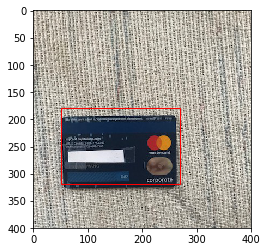

labels:  [ 51.533127 179.0233   268.67172  318.69974 ]


In [40]:
from keras.preprocessing.image import load_img
#path = "./input_data/GeneratedData_Train/000244.png"
path = "./input_data/card_test18.jpg"
origImg, dim = _load_image_data(path, False)
labels, img, dim = predict_imgPath(path)
print('image shape:', img.shape)
_show_image(origImg, labels[0], dim) 
print('labels: ', labels[0] * 400)

In [28]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
    
cardImage=Image.open(path)
cardImage = img_to_array(cardImage)
cardImage.shape

(400, 400, 4)

In [8]:
import matplotlib.pyplot as plt

In [15]:
pre_labels = predict(path)

AttributeError: 'NoneType' object has no attribute 'text'

In [16]:
from numpy import random
import numpy as np
from keras.preprocessing.image import load_img
import imageio
img_noscale = _load_image_data("./input_data/GeneratedData_Val/000000.png")
img = img_noscale /255


OSError: cannot identify image file './input_data/Annotations_Val/000001.xml'

In [34]:
image_batch = np.expand_dims(img, axis=0)
image_batch.shape

(1, 400, 400, 3)

In [43]:
pre_labels = model.predict(image_batch, batch_size=1)
pre_labels[0]

array([[0.23652619, 0.34742475, 0.8511678 , 0.7559838 ]], dtype=float32)

In [41]:
width = float('400.0')
height = float('400.0')
dim = [width, height]
dim[0]

400.0

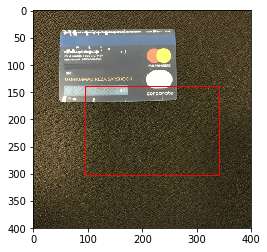

In [44]:
_show_image(img_noscale, pre_labels[0], dim)

image path:  ./input_data/Annotations_Val/000013.xml
labels:  [0.06, 0.0725, 0.6275, 0.4325] prediction labels:  [[0.06077931 0.07620601 0.6274685  0.43521038]]


<IPython.core.display.Javascript object>


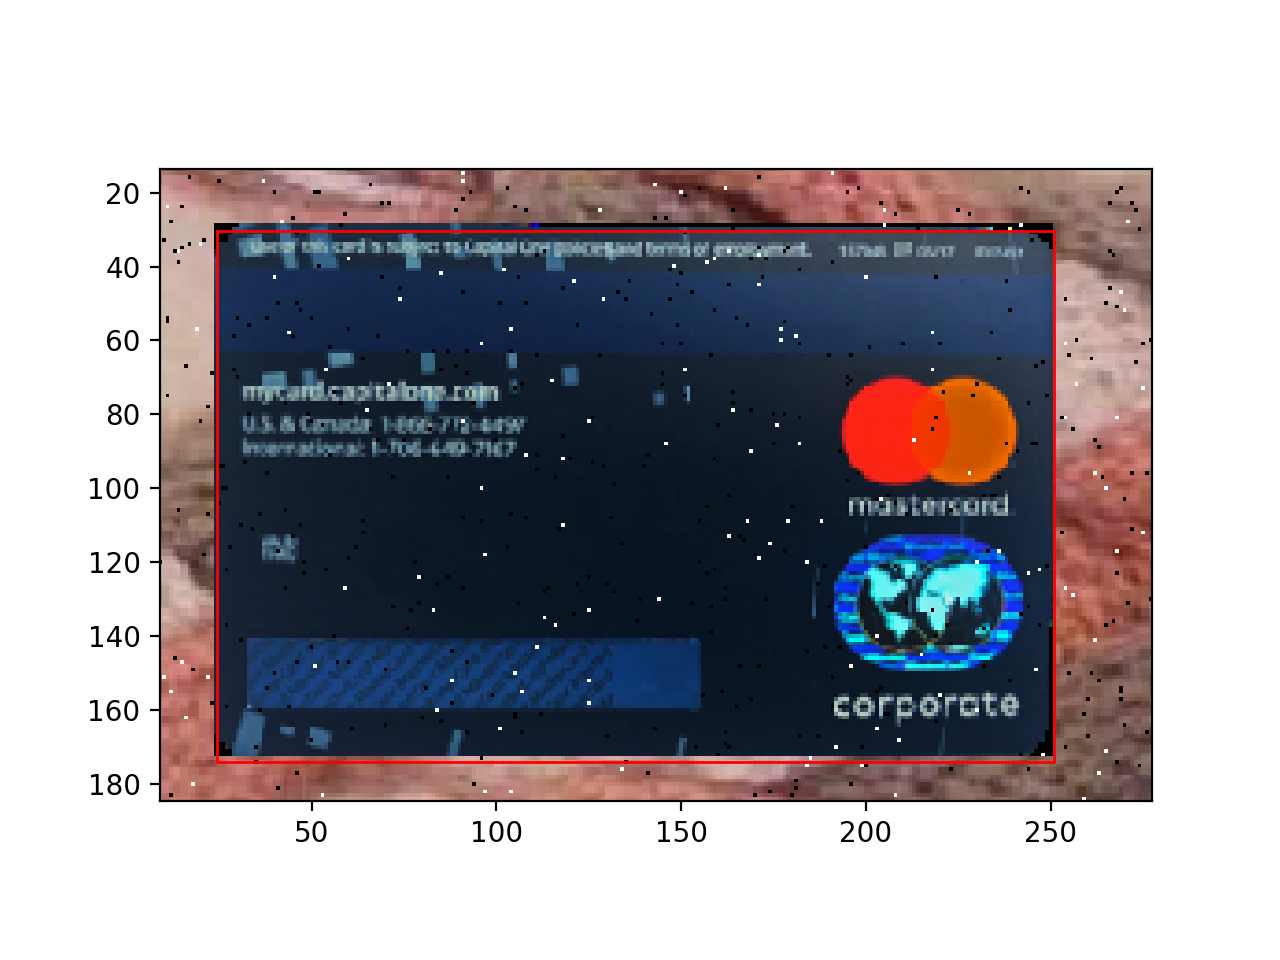

<IPython.core.display.Javascript object>


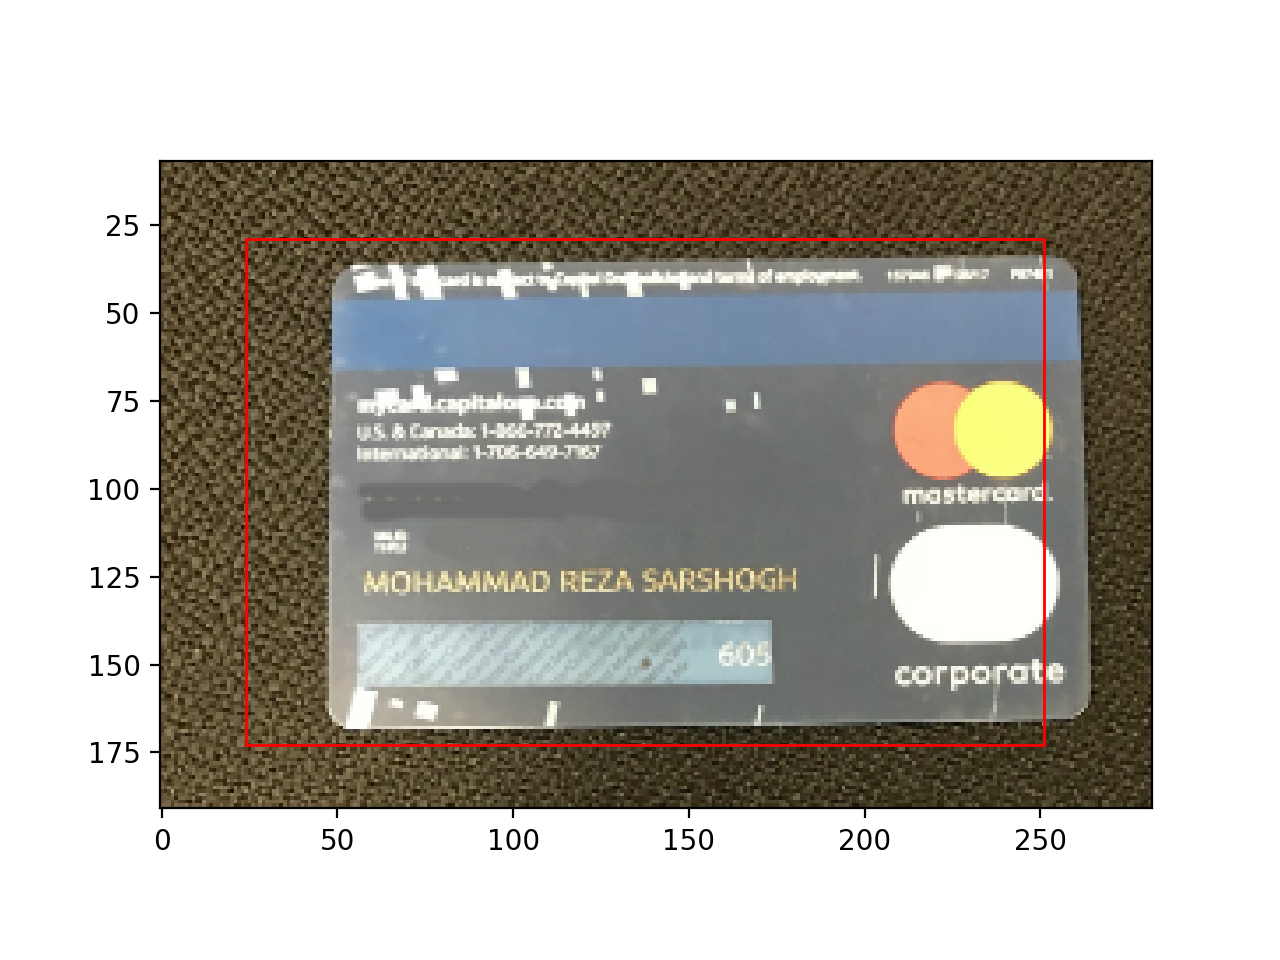

In [30]:
idx = 13
plt.figure(figsize=(10,10))
%matplotlib notebook
predict_labels, path = predict(annotation_validation_path, idx)
_show_image_path(annotation_validation_path,idx,predict_labels[0])
_show_image_path(annotation_validation_path,idx)

In [41]:
model.save('sunny_card_model.h5')

In [42]:
print(history.history.keys())

dict_keys(['loss'])


In [42]:
def _plot_loss_history(): 
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
    plt.show()

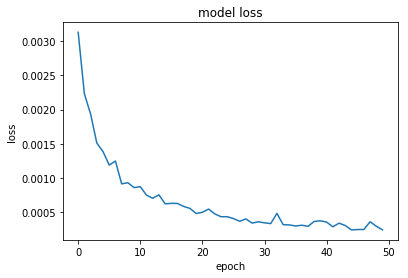

In [43]:
_plot_loss_history()